# Homework 3 - Luka Radić
## SCIPER: 354502

## Import the libraries needed

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
import torchvision.transforms as T
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, Subset, random_split
from typing import Optional

## Exercise 1: Backpropagation with logistic loss

We first define the `sigmoid` and `grad_sigmoid` functions that we will use throughout the exercise.

In [2]:
# Defining the constants used throughout the exercise
D = 5
K = 6

def sigmoid(x):
    return 1.0 / (1 + np.exp(-x))

def grad_sigmoid(x):
    return sigmoid(x) * (1 - sigmoid(x))

### Task 1: `predict` function

The `predict` function takes a batch of samples and the weights between input and hidden layers, as well as hidden and output layers, and returns a prediction in the interval $[0,1]$.

In [3]:
def predict(X,W):
    X_0 = X

    W_1 = W["w_1"]
    w_2 = W["w_2"]

    Z_1 = X_0 @ W_1
    X_1 = sigmoid(Z_1)
    z_2 = X_1 @ w_2
    y_hat = sigmoid(z_2)

    return Z_1, z_2, y_hat

### Task 2: `logistic_loss` function

In [4]:
def logistic_loss(y, y_hat):
    eps = 1e-12
    log_loss = -y.dot(np.log(y_hat+eps)) - (1-y).dot(np.log(1-y_hat+eps))
    return np.mean( log_loss )

In [5]:
B = 5 # esentially it can be anything, the result does not depend on it
y = np.zeros(B)
y_hat = np.zeros(B)
log_loss = logistic_loss(y, y_hat)
print("The average log-loss of the batch is {}".format(log_loss))

The average log-loss of the batch is -5.000444502909205e-12


### Task 3: `stable_logistic_loss` function

In [6]:
def stable_logistic_loss(y, z_2):
    log_loss = y.dot(np.logaddexp(0,-z_2)) + (1-y).dot(np.logaddexp(0,z_2))
    return np.mean( log_loss )

In [7]:
B = 5 # esentially it can be anything, the result does not depend on it
y = np.zeros(B)
z_2 = -1e10 * np.ones(B)
stable_log_loss = stable_logistic_loss(y, z_2)
print("The average stable-log-loss of the batch is {}".format(stable_log_loss))

The average stable-log-loss of the batch is 0.0


### Task 4: Analytical backpropagation

Let us denote with:
- $x_i^{(0)}$ the $i$-th component of the input vector
- $w_{ij}^{(1)}$ the weight of the edge connecting $x_i^{(0)}$ and the $j$-th node in the hidden layer $z_j^{(1)}$
- $w_j^{(2)}$ the weight of the edge connecting $z_j^{(1)}$ and the output node $z^{(2)}$
- $\hat{y}$ the final prediction

where $i=\overline{1,D},\; j=\overline{1,K}$. Note that the inputs of activation functions for each node in the NN can be calculated as:
$$
z_j^{(1)} = \sum_{i=1}^D \; w_{ij}^{(1)} x_i^{(0)}, \quad z^{(2)} = \sum_{j=1}^K \; w_j^{(2)} \sigma\left(z_j^{(1)}\right)
$$
We use the stable implementation of logistic loss:
$$
\mathcal{L}(x,y,w) = y \log\left( 1 + e^{-z^{(2)}} \right) + (1-y) \log\left( 1 + e^{z^{(2)}} \right)
$$

We first find the partial derivatives of *hidden-output* weights:
$$
\begin{align*}
    \frac{\partial \mathcal{L}(x,y,w)}{\partial w_j^{(2)}} &= - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} \frac{\partial z^{(2)}}{\partial w_j^{(2)}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \frac{\partial z^{(2)}}{\partial w_j^{(2)}} \\
    &= \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \; \sigma\left(z_j^{(1)}\right)
\end{align*}
$$

Now we find the partial derivatives of *input-hidden* weights. For that purpose, it is useful to rewrite $z^{(2)}$ as:
$$
z^{(2)} = \sum_{j=1}^K \; w_j^{(2)} \sigma\left(z_j^{(1)}\right) = \sum_{j=1}^K \; w_j^{(2)} \sigma\left(\sum_{i=1}^D \; w_{ij}^{(1)} x_i^{(0)}\right)
$$

$$
\begin{align*}
    \frac{\partial \mathcal{L}(x,y,w)}{\partial w_{ij}^{(1)}} &= \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \frac{\partial z^{(2)}}{\partial w_{ij}^{(1)}} \\
    &= \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \; w_j^{(2)} \sigma'\left(\sum_{i=1}^D \; w_{ij}^{(1)} x_i^{(0)}\right) x_i^{(0)}
\end{align*}
$$

Considering that
$$
\frac{d\sigma(x)}{dx} = \frac{e^{-x}}{(1+e^{-x})^2} = \frac{1}{1+e^{-x}} \left(\frac{1+e^{-x}}{1+e^{-x}}-\frac{1}{1+e^{-x}}\right) = \sigma(x)\left[1-\sigma(x)\right]
$$
we can finally write the partial derivative as
$$
    \frac{\partial \mathcal{L}(x,y,w)}{\partial w_{ij}^{(1)}} = \left[ - y \frac{e^{-z^{(2)}}}{1 + e^{-z^{(2)}}} + (1-y) \frac{e^{z^{(2)}}}{1 + e^{z^{(2)}}} \right] \; w_j^{(2)} \sigma\left(z_j^{(1)}\right)\left[1-\sigma\left(z_j^{(1)}\right)\right] x_i^{(0)}
$$

### Task 5: `gradient` function

In [8]:
def gradient(X, y, W):
    B = X.shape[0]
    # Feedforward
    Z_1, z_2, y_hat = predict(X, W)
    X_1 = sigmoid(Z_1)
    # Backpropagation
    delta_2 = -y * np.exp(-z_2)/(1+np.exp(-z_2)) + (1-y)*np.exp(z_2)/(1+np.exp(z_2))
    delta_w_2 = delta_2.reshape(-1,1) * X_1
    delta_w_2_mean = np.mean(delta_w_2, axis=0)
    delta_1 = delta_2.reshape(-1,1) * grad_sigmoid(Z_1) * W["w_2"]
    delta_w_1_mean = 1/B * X.T @ delta_1
    
    return {
        "w_1": delta_w_1_mean,
        "w_2": delta_w_2_mean
    }

In [9]:
X = np.array([[0.3,0.3,0.3,0.3],[0.3,0.3,0.3,0.3],[0.01,0.2,0.01,0.3],[0.3,0.3,0.3,0.3]])
W = {
    "w_1": np.ones((4, 5)),
    "w_2": np.ones(5)
}
y = np.ones(4)

In [10]:

expected = 0.93244675427215695
_, _, yours = predict(X, W)
print(yours)
print(np.sum((yours - expected) ** 2) < 1e-15)

[0.97901263 0.97901263 0.9583431  0.97901263]
False


In [11]:

expected = {
    'w_1': np.array([
        [ -1.06113639e-05,  -1.06113639e-05,  -1.06113639e-05, -1.06113639e-05,  -1.06113639e-05],
        [ -2.12227277e-05,  -2.12227277e-05,  -2.12227277e-05, -2.12227277e-05,  -2.12227277e-05],
        [ -3.18340916e-05,  -3.18340916e-05,  -3.18340916e-05, -3.18340916e-05,  -3.18340916e-05],
        [ -4.24454555e-05,  -4.24454555e-05,  -4.24454555e-05, -4.24454555e-05,  -4.24454555e-05]]),
    'w_2': np.array(
        [-0.00223387, -0.00223387, -0.00223387, -0.00223387, -0.00223387])
}
yours = gradient(X,y,W)
print(yours)
print( np.sum(
    [np.sum((yours[key] - expected[key]) ** 2) for key in expected.keys()]) < 1e-15 )


{'w_1': array([[-0.0008644 , -0.0008644 , -0.0008644 , -0.0008644 , -0.0008644 ],
       [-0.00132708, -0.00132708, -0.00132708, -0.00132708, -0.00132708],
       [-0.0008644 , -0.0008644 , -0.0008644 , -0.0008644 , -0.0008644 ],
       [-0.0015706 , -0.0015706 , -0.0015706 , -0.0015706 , -0.0015706 ]]), 'w_2': array([-0.01862824, -0.01862824, -0.01862824, -0.01862824, -0.01862824])}
False


## Exercise 2: Classifying `FashionMNIST` using neural networks

### Task 1: Loading data

We load the train and test datasets. For our new train and validation sets, we take random subsets of the original training set, 50000 and 10000 images each. Since the images are in the PIL format, we need to convert them to tensors using `ToTensor()` transformation.

In [12]:
IMAGE_SIZE = 28*28

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor()
])

# Load the training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# Make a validation dataset by splitting the original training one
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(456)
)

# Load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

Our datasets are quite large, so we cannot update them on a sample basis. Thus, we will train them in *batches*, which means that the model weights are updated only after a predefined number of samples have been "feed-forwarded". For that purpose, we construct dataloaders - wrappers for our train/test datasets.

In [13]:
# Define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024
LEARNING_RATE = 0.01

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

cuda


Let us visualize some of the samples.

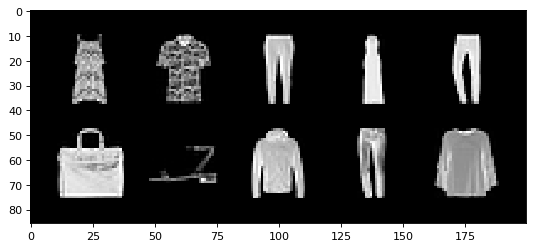

In [14]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,6), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

### Task 2: MultiLayer Perceptron (MLP)

Now we define our MLP architecture with two hidden layers of 100 neurons each. Not that the `ReLU` is defined twice - for each hidden layer. Although ReLU is not layer-specific and without learnable parameters, meaning that it is always calling into a stateless function `max(0, x)`, some problems have been reported when using unique ReLU realization for every layer.

In [15]:
class Net(nn.Module):
  def __init__(self):
    super().__init__()
    # first hidden layer
    self.fc1 =  nn.Linear(IMAGE_SIZE, 100)
    self.relu1 = nn.ReLU()
    # second hidden layer
    self.fc2 = nn.Linear(100, 100)
    self.relu2 = nn.ReLU()
    # output layer; we have 10 classes
    self.fc3 = nn.Linear(100, 10)

  def forward(self, x: torch.Tensor) -> torch.Tensor:
    batch_size = x.shape[0]
    # flattening the images
    x = x.view(batch_size, -1)

    # forwardpass
    x = self.fc1(x)
    x = self.relu1(x)
    x = self.fc2(x)
    x = self.relu2(x)
    x = self.fc3(x)
    
    return x

We now define the functons `train_epoch` which contains the training logic during one training epoch.

In [16]:
def train_epoch(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target) in enumerate(train_dataloader):
        # move data and target to device
        data, target = data.to(device), target.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # do the forward pass
        output = model(data)
        # compute the loss
        loss = F.cross_entropy(output, target)
        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)

Next, we define the `predict` method, which evaluates how well our trained model performs on the test set. It is also used during training with cross-validation on the validation dataset to detect overfitting.

In [17]:
def predict(model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = F.cross_entropy(output, target)#, reduction="sum")
            test_loss += loss.item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / len(test_dataloader.dataset)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

Finally, we define the `fit` method, which contains all the logic for full model training with the possibility of cross-validation.

In [18]:
def fit(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

After we have defined all the training and evaluation "machinery", we can finally start the training process. We define the number of epochs and four different types of optimizers we want to test.

In [19]:
EPOCHS = 20

models = [Net(), Net(), Net(), Net()]
for model in models:
  model.to(DEVICE)

optimizers = []
optimizers.append(optim.SGD(models[0].parameters(), lr=0.01))
optimizers.append(optim.SGD(models[1].parameters(), lr=0.01, momentum=0.9, nesterov=True))
optimizers.append(optim.Adam(models[2].parameters(), lr=0.01))
optimizers.append(optim.Adam(models[3].parameters(), lr=1))

names = [
    'Optimizer: SGD, lr=0.01',
    'Optimizer: SGD, lr=0.01, momentum=0.9',
    'Optimizer: Adam, lr=0.01',
    'Optimizer: Adam, lr=1'
]

In [20]:
train_losses_models_MLP = {}
valid_losses_models_MLP = {}

for i in range(len(models)):
  model = models[i]
  optimizer = optimizers[i]

  train_losses, valid_losses, valid_accs = fit(
        model=model, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=DEVICE
    )
  
  train_losses_models_MLP[i] = train_losses
  valid_losses_models_MLP[i] = valid_losses

  print(f"%"*100)
  print(f"Trial [{names[i]}]: Validation accuracy = {valid_accs[-1]:.4f}")
  print(f"%"*100)

Epoch 0: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=21.9600
Epoch 1: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=28.6800
Epoch 2: Train Loss=0.0021, Validation Loss=0.0021, Validation acc=45.6800
Epoch 3: Train Loss=0.0020, Validation Loss=0.0020, Validation acc=53.2600
Epoch 4: Train Loss=0.0019, Validation Loss=0.0019, Validation acc=55.5700
Epoch 5: Train Loss=0.0018, Validation Loss=0.0017, Validation acc=56.3600
Epoch 6: Train Loss=0.0016, Validation Loss=0.0015, Validation acc=59.5500
Epoch 7: Train Loss=0.0014, Validation Loss=0.0014, Validation acc=61.0300
Epoch 8: Train Loss=0.0013, Validation Loss=0.0013, Validation acc=62.0200
Epoch 9: Train Loss=0.0012, Validation Loss=0.0012, Validation acc=63.6100
Epoch 10: Train Loss=0.0011, Validation Loss=0.0011, Validation acc=64.7600
Epoch 11: Train Loss=0.0010, Validation Loss=0.0010, Validation acc=65.9300
Epoch 12: Train Loss=0.0010, Validation Loss=0.0010, Validation acc=66.2500
Epoch 13: Train Loss=0

In [21]:
for model in models:
  predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0008, Accuracy: 7018/10000 (70%)
Test set: Avg. loss: 0.0005, Accuracy: 8388/10000 (84%)
Test set: Avg. loss: 0.0004, Accuracy: 8794/10000 (88%)
Test set: Avg. loss: 0.0023, Accuracy: 1000/10000 (10%)


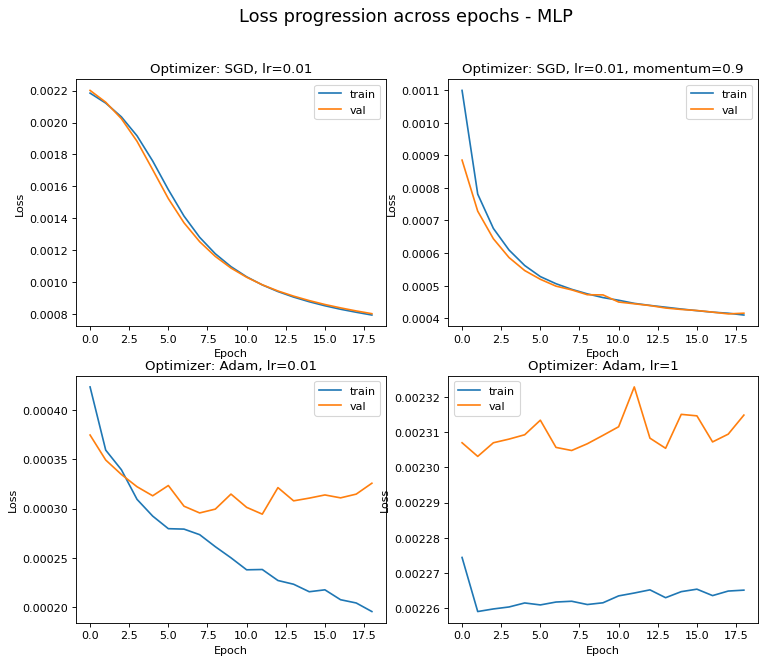

In [22]:
fig = plt.figure(figsize=(11,9), dpi=80)
plt.suptitle('Loss progression across epochs - MLP', fontsize=16)

for i in range(len(models)):
  plt.subplot(2,2,i+1)
  plt.title(names[i])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(train_losses_models_MLP[i][1:], label='train')
  plt.plot(valid_losses_models_MLP[i][1:], label='val')
  plt.legend(fontsize=10)

### Task 3: Convolutional Neural Network (CNN)

We first create a CNN model.

In [23]:
class CNN(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, stride=1, padding=1),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2),
    )

    # Fully connected output layer
    self.out = nn.Linear(576, 10)

  def forward(self, x):
    # propagate through convolutional layers
    x = self.conv(x)
    # flattening the "convolutional" output
    x = x.view(x.size(0), -1)
    # propagate through FC layer
    x = self.out(x)

    return x


We repeat the same training procedure as with the MLP. We set the number of epochs to 20 and test on four different optimizers.

In [24]:
EPOCHS = 20

models = [CNN(), CNN(), CNN(), CNN()]
for model in models:
  model.to(DEVICE)

optimizers = []
optimizers.append(optim.SGD(models[0].parameters(), lr=0.01))
optimizers.append(optim.SGD(models[1].parameters(), lr=0.01, momentum=0.9, nesterov=True))
optimizers.append(optim.Adam(models[2].parameters(), lr=0.01))
optimizers.append(optim.Adam(models[3].parameters(), lr=1))

names = [
    'Optimizer: SGD, lr=0.01',
    'Optimizer: SGD, lr=0.01, momentum=0.9',
    'Optimizer: Adam, lr=0.01',
    'Optimizer: Adam, lr=1'
]

In [25]:
train_losses_models_CNN = {}
valid_losses_models_CNN = {}

for i in range(len(models)):
  model = models[i]
  optimizer = optimizers[i]

  train_losses, valid_losses, valid_accs = fit(
        model=model, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer,
        epochs=EPOCHS,
        device=DEVICE
    )
  
  train_losses_models_CNN[i] = train_losses
  valid_losses_models_CNN[i] = valid_losses

  print(f"%"*100)
  print(f"Trial [{names[i]}]: Validation accuracy = {valid_accs[-1]:.4f}")
  print(f"%"*100)

Epoch 0: Train Loss=0.0023, Validation Loss=0.0023, Validation acc=11.8300
Epoch 1: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=27.1000
Epoch 2: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=32.8300
Epoch 3: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=33.6500
Epoch 4: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=32.8900
Epoch 5: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=33.9300
Epoch 6: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=35.9200
Epoch 7: Train Loss=0.0021, Validation Loss=0.0020, Validation acc=42.6700
Epoch 8: Train Loss=0.0019, Validation Loss=0.0017, Validation acc=53.4700
Epoch 9: Train Loss=0.0014, Validation Loss=0.0012, Validation acc=63.5100
Epoch 10: Train Loss=0.0010, Validation Loss=0.0010, Validation acc=67.5800
Epoch 11: Train Loss=0.0009, Validation Loss=0.0009, Validation acc=65.6900
Epoch 12: Train Loss=0.0009, Validation Loss=0.0010, Validation acc=66.0600
Epoch 13: Train Loss=0

In [26]:
for model in models:
  predict(model=model, test_dataloader=test_dataloader, device=DEVICE)

Test set: Avg. loss: 0.0008, Accuracy: 7368/10000 (74%)
Test set: Avg. loss: 0.0004, Accuracy: 8584/10000 (86%)
Test set: Avg. loss: 0.0003, Accuracy: 9053/10000 (91%)
Test set: Avg. loss: 0.0023, Accuracy: 1000/10000 (10%)


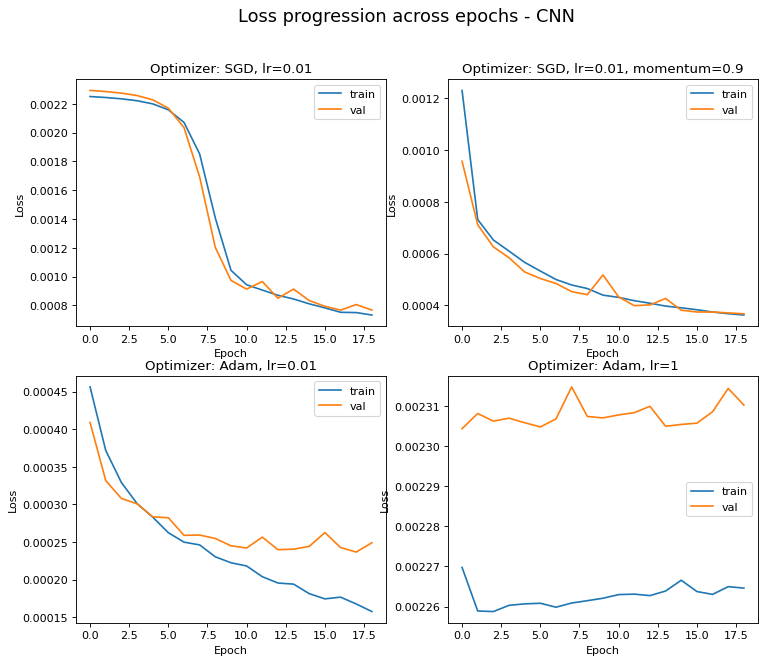

In [27]:
fig = plt.figure(figsize=(11,9), dpi=80)
plt.suptitle('Loss progression across epochs - CNN', fontsize=16)

for i in range(len(models)):
  plt.subplot(2,2,i+1)
  plt.title(names[i])
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.plot(train_losses_models_CNN[i][1:], label='train')
  plt.plot(valid_losses_models_CNN[i][1:], label='val')
  plt.legend(fontsize=10)

#### CNN IMAJU LOKALNU INFORMACIJU

### Task 4: Number of model parameters

We define a function `num_parameters` that returns a number of all parameters for a given model, including the non-trainable ones (note that our MLP and CNN models do not have non-trainable parameters).

In [28]:
def num_parameters(model: nn.Module) -> int:
  return sum(
      param.numel() for param in model.parameters()
  )

We calculate the number of parameters our MLP and CNN models have.

In [29]:
mlp = Net()
cnn = CNN()
num_mlp = num_parameters(mlp)
num_cnn = num_parameters(cnn)

print(f"Number of parameters in the MLP model: {num_mlp}")
print(f"Number of parameters in the CNN model: {num_cnn}")

Number of parameters in the MLP model: 89610
Number of parameters in the CNN model: 29066


The number of CNN parameters is 3 times lower than the MLP case but our previous analysis shows that, despite this, the CNN performed better. Thus we conclude that having more parameters does not translate to better performance. But why is this the case?

CNNs are designed specifically to work with images, where neighboring pixels are expected to be highly correlated, while distant pixels have high probability of being "independent". The kernel convolution is defined to aggregate the local information of a pixel, so not all the inputs in the layer affect the outputs of the next layer. On the contrary, when working with images, fully connected networks first flatten them and then connect all the inputs to all the output nodes. Not only do the FC networks have more parameters (weights), but since the natural order of the image is lost, they perform worse than the CNNs.

### Task 5: Classification with `PermutedFashionMNIST`

We define a `RandomPermutation` transformation which randomly redistributes pixels in an image.

In [30]:
class RandomPermutation(object):
    def __init__(self, num_features):
        self.num_features = num_features
        self.reindex = torch.randperm(num_features)
    
    def __call__(self, img):
        assert self.num_features == img.numel()
        orig_shape = img.shape
        img = img.view(-1)[self.reindex].view(orig_shape)
        return img

We load the data as in *Task 1*, but now we add our `RandomPermutation` to the list of transformations.

In [31]:
IMAGE_SIZE = 28*28

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor(),
    RandomPermutation(IMAGE_SIZE)
])

# Load the training dataset
train_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

# Make a validation dataset by splitting the original training one
train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(456)
)

# Load the test dataset
test_dataset = torchvision.datasets.FashionMNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

Again, we construct the dataloaders and define the batch sizes.

In [32]:
# Define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

cuda


Let us visualize a few samples to make sure the pixels were indeed permuted.

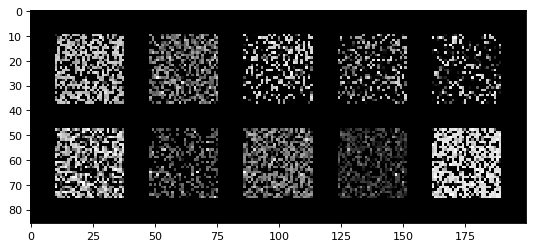

In [33]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(8,6), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

Now, we define the hyperparameters and initialize the MLP/CNN models and optimizers.

In [34]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 20

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

model_mlp = Net().to(DEVICE)
model_cnn = CNN().to(DEVICE)

optimizer_mlp = optim.SGD(model_mlp.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)
optimizer_cnn = optim.SGD(model_cnn.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)

cuda


The next step is training both models.

In [35]:
# Training the MLP model
print(f"%"*100)
print(f"Training the MLP model")
print(f"%"*100)
train_losses_mlp, valid_losses_mlp, valid_accs_mlp = fit(
        model=model_mlp, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_mlp,
        epochs=EPOCHS,
        device=DEVICE
    )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Training the MLP model
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 0: Train Loss=0.0021, Validation Loss=0.0016, Validation acc=49.7900
Epoch 1: Train Loss=0.0011, Validation Loss=0.0009, Validation acc=67.9200
Epoch 2: Train Loss=0.0008, Validation Loss=0.0007, Validation acc=73.0700
Epoch 3: Train Loss=0.0007, Validation Loss=0.0006, Validation acc=76.6500
Epoch 4: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=79.2800
Epoch 5: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=80.7900
Epoch 6: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=81.7800
Epoch 7: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=82.4000
Epoch 8: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=83.0200
Epoch 9: Train Loss=0.0005, Validation Loss=0.0005, Validation acc=83.1300
Epoch 10: Train Loss=0.00

In [36]:
# Training the CNN model
print(f"%"*100)
print(f"Training the CNN model")
print(f"%"*100)
train_losses_cnn, valid_losses_cnn, valid_accs_cnn = fit(
        model=model_cnn, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_cnn,
        epochs=EPOCHS,
        device=DEVICE
    )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Training the CNN model
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 0: Train Loss=0.0022, Validation Loss=0.0023, Validation acc=25.6500
Epoch 1: Train Loss=0.0021, Validation Loss=0.0019, Validation acc=36.9000
Epoch 2: Train Loss=0.0017, Validation Loss=0.0016, Validation acc=47.7100
Epoch 3: Train Loss=0.0013, Validation Loss=0.0011, Validation acc=62.3900
Epoch 4: Train Loss=0.0010, Validation Loss=0.0009, Validation acc=69.8400
Epoch 5: Train Loss=0.0008, Validation Loss=0.0008, Validation acc=73.3600
Epoch 6: Train Loss=0.0007, Validation Loss=0.0007, Validation acc=73.2600
Epoch 7: Train Loss=0.0007, Validation Loss=0.0007, Validation acc=76.5100
Epoch 8: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=77.4000
Epoch 9: Train Loss=0.0006, Validation Loss=0.0006, Validation acc=76.9700
Epoch 10: Train Loss=0.00

We predict the test set labels and calculate the corresponding metrics.

In [37]:
print('Predictions using the MLP: ')
predict(model=model_mlp, test_dataloader=test_dataloader, device=DEVICE)

print('Predictions using the CNN: ')
predict(model=model_cnn, test_dataloader=test_dataloader, device=DEVICE)

Predictions using the MLP: 
Test set: Avg. loss: 0.0005, Accuracy: 8353/10000 (84%)
Predictions using the CNN: 
Test set: Avg. loss: 0.0005, Accuracy: 8188/10000 (82%)


(0.0005079107701778412, tensor(81.8800, device='cuda:0'))

Now we plot the train/val curves for both models.

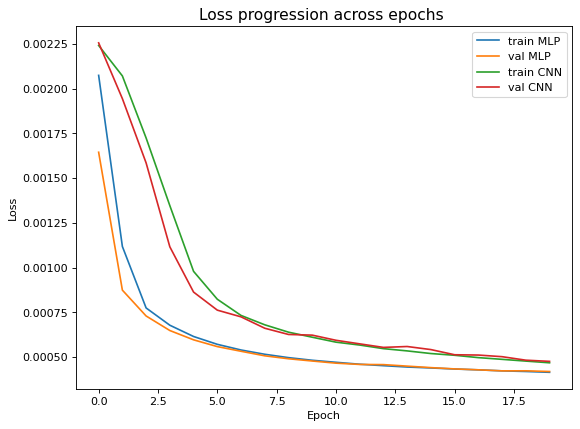

In [38]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.title('Loss progression across epochs ', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses_mlp, label='train MLP')
plt.plot(valid_losses_mlp, label='val MLP')
plt.plot(train_losses_cnn, label='train CNN')
plt.plot(valid_losses_cnn, label='val CNN')
plt.legend(fontsize=10)

## Exercise 3: Multi-Task Learning with `MultiMNIST`

### Task 1: Function `make_new_sample`

In [39]:
def make_new_sample(x1: torch.Tensor, x2: torch.Tensor) -> torch.Tensor:
  res = torch.zeros((1,36,36))
  res[0, :28, :28] = x1
  res[0, 8:, 8:] = torch.maximum(res[0, 8:, 8:], x2)
  return res

### Task 2: Creating the `MultiMNIST` dataset

In [40]:
TRAIN_SIZE = 60000
TEST_SIZE = 10000

# The data are given as PIL images. We need to convert our data to a type 
# that is readable by a Neural Network. Thus, we use the ToTensor() "transform" 
transform = T.Compose([
    T.ToTensor()
])

train_mnist = torchvision.datasets.MNIST(
    root='./data/', 
    train=True, 
    download=True,
    transform=transform)

test_mnist = torchvision.datasets.MNIST(
    root='./data/', 
    train=False, 
    download=True,
    transform=transform)

In [41]:
train_indices = np.random.randint(low=0, high=TRAIN_SIZE, size=(TRAIN_SIZE,2))
test_indices = np.random.randint(low=0, high=TEST_SIZE, size=(TEST_SIZE,2))

# Creating training samples and labels
train_multimnist_samples = []
train_multimnist_label1 = []
train_multimnist_label2 = []
for i in range(TRAIN_SIZE):
  img1 = train_indices[i][0]
  img2 = train_indices[i][1]
  multi_image = make_new_sample(train_mnist[img1][0][0], train_mnist[img2][0][0])
  train_multimnist_samples.append(multi_image)
  train_multimnist_label1.append(train_mnist[img1][1])
  train_multimnist_label2.append(train_mnist[img2][1])

# Creating test samples and labels
test_multimnist_samples = []
test_multimnist_label1 = []
test_multimnist_label2 = []
for i in range(TEST_SIZE):
  img1 = test_indices[i][0]
  img2 = test_indices[i][1]
  multi_image = make_new_sample(test_mnist[img1][0][0], test_mnist[img2][0][0])
  test_multimnist_samples.append(multi_image)
  test_multimnist_label1.append(test_mnist[img1][1])
  test_multimnist_label2.append(test_mnist[img2][1])

In [42]:
class MultiMNIST(Dataset):
  def __init__(self, samples, label1, label2):
    self.samples = samples
    self.label1 = label1
    self.label2 = label2

  def __len__(self):
    return len(self.samples)

  def __getitem__(self, idx):
    return self.samples[idx], self.label1[idx], self.label2[idx]

In [43]:
train_dataset = MultiMNIST(train_multimnist_samples, train_multimnist_label1, train_multimnist_label2)

train_dataset,  valid_dataset = random_split(
    train_dataset, 
    lengths=[50000, 10000], 
    generator=torch.Generator().manual_seed(456)
)

test_dataset = MultiMNIST(test_multimnist_samples, test_multimnist_label1, test_multimnist_label2)

In [44]:
# Define the hyperparameters
BATCH_SIZE = 1024
TEST_BATCH_SIZE = 1024

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

# construct the dataloader for the traininig dataset. 
# Here we shuffle the data to promote stochasticity.
train_dataloader = DataLoader(
    dataset=train_dataset, 
    batch_size=BATCH_SIZE,
    shuffle=True, 
    num_workers=2)

valid_dataloader = DataLoader(
    dataset=valid_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

# Construct the dataloader for the testing dataset.
test_dataloader = DataLoader(
    dataset=test_dataset, 
    batch_size=TEST_BATCH_SIZE,
    shuffle=False, 
    num_workers=2)

cuda


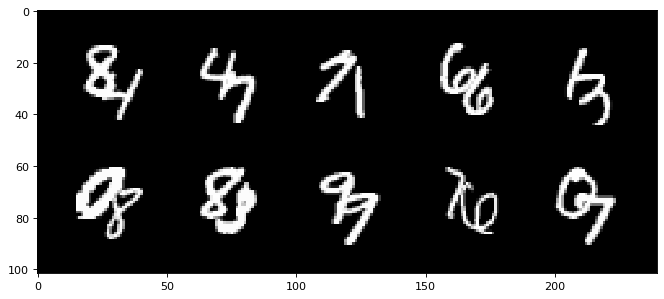

In [45]:
# Get the first 10 images of the train dataset. Hint: use next(), iter()
images = next(iter(train_dataloader))[0][:10]
grid = torchvision.utils.make_grid(images, nrow=5, padding=10)

def show(img):
    npimg = img.numpy()
    plt.figure(figsize=(10,8), dpi=80)
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

show(grid)

### Task 3: Creating the Multi-Task model

In [46]:
class MultiTaskModel(nn.Module):
  def __init__(self):
    super().__init__()

    self.conv = nn.Sequential(
      nn.Conv2d(in_channels=1, out_channels=10, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2),
      nn.Conv2d(in_channels=10, out_channels=20, kernel_size=5, stride=1, padding=2),
      nn.ReLU(),
      nn.MaxPool2d(kernel_size=2)
    )
    self.linear = nn.Linear(1620,50)
    self.out1 = nn.Linear(50,10)
    self.out2 = nn.Linear(50,10)

  def forward(self, x):
    # propagate through convolutional layers
    x = self.conv(x)
    # flattening the "convolutional" output
    x = x.view(x.size(0), -1)
    # propagate through FC layer
    x = self.linear(x)

    # decode first image
    x1 = self.out1(x)
    # decode second image
    x2 = self.out2(x)

    return x1, x2

### Task 4: Training the Multi-Task model

In [47]:
def train_epoch_multi(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    device: torch.device
    ):
    '''
    This function implements the core components of any Neural Network training regiment.
    In our stochastic setting our code follows a very specific "path". First, we load the batch
    a single batch and zero the optimizer. Then we perform the forward pass, compute the gradients and perform the backward pass. And ...repeat!
    '''

    running_loss = 0.0
    model = model.to(device)
    model.train()
    for batch_idx, (data, target1, target2) in enumerate(train_dataloader):
        # move data and target to device
        data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
        # zero the parameter gradients
        optimizer.zero_grad()
        # do the forward pass
        output1, output2 = model(data)
        # compute the loss
        loss1, loss2 = F.cross_entropy(output1, target1), F.cross_entropy(output2, target2)
        loss = (loss1 + loss2) / 2

        # compute the gradients
        loss.backward()

        # perform the gradient step
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
    
    return running_loss / len(train_dataloader.dataset)

In [48]:
def fit_multi(
    model: nn.Module, 
    train_dataloader: DataLoader, 
    optimizer: torch.optim.Optimizer, 
    epochs: int, 
    device: torch.device,
    valid_dataloader: Optional[DataLoader]=None):
    '''
    the fit method simply calls the train_epoch() method for a 
    specified number of epochs.
    '''

    # keep track of the losses in order to visualize them later
    # Train for numerous epochs:
    train_losses = []
    valid_losses = []
    valid_accs = []
    for epoch in range(epochs):
        train_loss = train_epoch_multi(
            model=model, 
            train_dataloader=train_dataloader, 
            optimizer=optimizer, 
            device=device
        )
        train_losses.append(train_loss)

        if valid_dataloader is not None:
            valid_loss, valid_acc = predict_multi(model, valid_dataloader, device, verbose=False)
            valid_losses.append(valid_loss)
            valid_accs.append(valid_acc)

        if valid_dataloader is None:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}")
        else:
            print(f"Epoch {epoch}: Train Loss={train_loss:.4f}, Validation Loss={valid_loss:.4f}, Validation acc={valid_acc:.4f}")

    return train_losses, valid_losses, valid_accs

In [49]:
def predict_multi(model: nn.Module, test_dataloader: DataLoader, device: torch.device, verbose=True):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target1, target2 in test_dataloader:
            data, target1, target2 = data.to(device), target1.to(device), target2.to(device)
            output1, output2 = model(data)
            loss1, loss2 = F.cross_entropy(output1, target1), F.cross_entropy(output2, target2)
            loss = (loss1 + loss2) / 2
            test_loss += loss.item()
            pred1 = output1.data.max(1, keepdim=True)[1]
            pred2 = output2.data.max(1, keepdim=True)[1]
            correct += pred1.eq(target1.data.view_as(pred1)).sum() + pred2.eq(target2.data.view_as(pred2)).sum()

    test_loss /= len(test_dataloader.dataset)
    accuracy = 100.0 * correct / (len(test_dataloader.dataset)*2)

    if verbose:
        print(
            f"Test set: Avg. loss: {test_loss:.4f}, Accuracy: {correct}/{2*len(test_dataloader.dataset)} ({accuracy:.0f}%)"
        )

    return test_loss, accuracy

In [50]:
LEARNING_RATE = 0.01
MOMENTUM = 0.9
EPOCHS = 20

# Find out which device is available
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(DEVICE)

model_mtm = MultiTaskModel()

optimizer_mtm = optim.SGD(model_mtm.parameters(), lr=LEARNING_RATE, momentum=MOMENTUM, nesterov=True)

cuda


In [51]:
# Training the MultiTask model
print(f"%"*100)
print(f"Training the MultiTask model")
print(f"%"*100)
train_losses_mtm, valid_losses_mtm, valid_accs_mtm = fit_multi(
        model=model_mtm, 
        train_dataloader=train_dataloader,
        valid_dataloader=valid_dataloader,
        optimizer=optimizer_mtm,
        epochs=EPOCHS,
        device=DEVICE
    )

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Training the MultiTask model
%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%
Epoch 0: Train Loss=0.0022, Validation Loss=0.0022, Validation acc=36.7850
Epoch 1: Train Loss=0.0016, Validation Loss=0.0008, Validation acc=76.8300
Epoch 2: Train Loss=0.0006, Validation Loss=0.0005, Validation acc=86.2250
Epoch 3: Train Loss=0.0004, Validation Loss=0.0004, Validation acc=88.8250
Epoch 4: Train Loss=0.0003, Validation Loss=0.0003, Validation acc=90.2300
Epoch 5: Train Loss=0.0003, Validation Loss=0.0003, Validation acc=91.6850
Epoch 6: Train Loss=0.0003, Validation Loss=0.0003, Validation acc=92.4150
Epoch 7: Train Loss=0.0002, Validation Loss=0.0002, Validation acc=93.1750
Epoch 8: Train Loss=0.0002, Validation Loss=0.0002, Validation acc=93.8050
Epoch 9: Train Loss=0.0002, Validation Loss=0.0002, Validation acc=94.0600
Epoch 10: Train Los

In [52]:
print('Predictions using the MultiTask model: ')
predict_multi(model=model_mtm, test_dataloader=test_dataloader, device=DEVICE)

Predictions using the MultiTask model: 
Test set: Avg. loss: 0.0001, Accuracy: 19200/20000 (96%)


(0.00012554885298013687, tensor(96., device='cuda:0'))

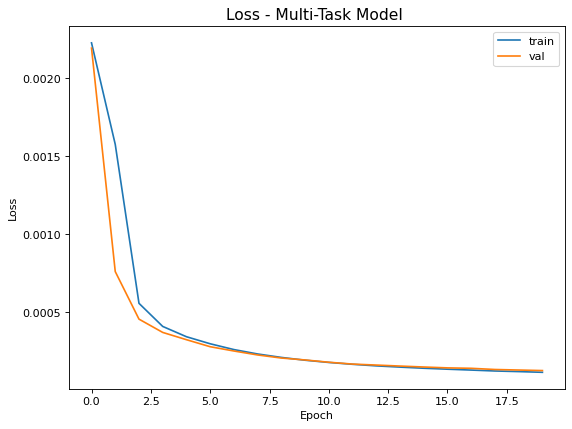

In [53]:
fig = plt.figure(figsize=(8,6), dpi=80)
plt.title('Loss - Multi-Task Model ', fontsize=14)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.plot(train_losses_mtm, label='train')
plt.plot(valid_losses_mtm, label='val')
plt.legend(fontsize=10)